In [5]:
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
from ucimlrepo import fetch_ucirepo 
import pandas as pd
import sys
sys.path.append("../")
import models
from utils.training import train_meta_model, train_gp
from utils.gp_data import obtain_me_a_nice_gp_dataset_please
from utils.data_utils import ctxt_trgt_split

torch.set_default_dtype(torch.float64)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Download Data

In [6]:
# fetch dataset 
tetouan_dataset = fetch_ucirepo(id=849) 
  
# data (as pandas dataframes) 
all_X = tetouan_dataset.data.features 
all_y = tetouan_dataset.data.targets 

# what features does the dataset have?
print(all_X.columns)

Index(['DateTime', 'Temperature', 'Humidity', 'Wind Speed',
       'general diffuse flows', 'diffuse flows'],
      dtype='object')


##### Convert to normalised torch tensors, split.

In [7]:
date_times = pd.to_datetime(all_X['DateTime'], format="%m/%d/%Y %H:%M")
first_datetime = date_times[0]
# convert time to days
dt = torch.tensor(((date_times - first_datetime).dt.total_seconds() / (24 * 3600)).astype(float).values).unsqueeze(-1)
temp_humid = torch.tensor(all_X[['Temperature', 'Humidity']].values)

feb_idx = int((31 / 365) * dt.shape[0])
mar_idx = int((59 / 365) * dt.shape[0])

# pre-feb datasets:
unnorm_X = torch.cat((dt, temp_humid), -1)[:feb_idx]
unnorm_ys = [torch.tensor(all_y[col].values)[:feb_idx] for col in all_y.columns]

X_mean, X_std = unnorm_X.mean(0), unnorm_X.std(0)
y_mean, y_std = torch.tensor(all_y.values)[:feb_idx].mean(), torch.tensor(all_y.values)[:feb_idx].std()

X = (unnorm_X - X_mean) / X_std
ys = [(unnorm_y - y_mean) / y_std for unnorm_y in unnorm_ys]

md = [(X, ys[0]), (X, ys[2])]

zone2_ctxt = (X, ys[1])

# feb test dataset for zone 2:
feb_unnorm_X = torch.cat((dt, temp_humid), -1)[feb_idx:mar_idx]
feb_unnorm_y2 = torch.tensor(all_y.iloc[:,1].values)[feb_idx:mar_idx]

feb_X = (feb_unnorm_X - X_mean) / X_std
feb_y2 = (feb_unnorm_y2 - y_mean) / y_std

zone2_trgt = (feb_X, feb_y2)

In [9]:
print(feb_X.shape)

torch.Size([4021, 3])


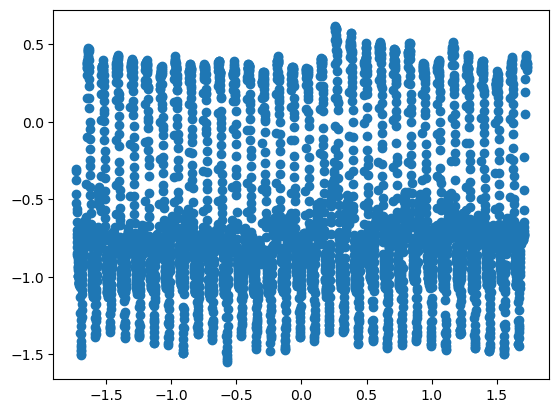

In [29]:
plt.scatter(md[0][0][:,0], md[1][1])
plt.show()

### Initialise Models

In [12]:
cnn_chans = [32, 32]
kernel_size = 3
Z_net_width = 128
Z_net_depth = 3
use_transformer = False
num_induc = 128
d_k = 8
tetouan_grid_spacing = [2.5e-2, 1e0, 1e0]
p1_raw = 1.0 # daily period
p2_raw = 7.0 # weekly period

# prior = sparse_gp.GPPrior(covariance_function='tetouan',
#                           num_inputs=3,
#                           p1=p1_raw / X_std[0],
#                           p2=p2_raw / X_std[0],
#                          )

# sgnp = sparse_gp.SparseGaussianNeuralProcess(
#     x_dim=3,
#     num_inducing=num_induc,
#     likelihood=sparse_gp.GaussianLikelihood(sigma_y = 0.02, train_sigma_y=True),
#     prior=prior,
#     cnn_hidden_chans=cnn_chans,
#     cnn_kernel_size=kernel_size,
#     d_k=d_k,
#     Z_net_width=Z_net_width,
#     Z_net_hidden_depth=Z_net_depth,
#     use_transformer=use_transformer,
#     nonlinearity=torch.nn.ELU(),
#     use_titsias=True,
#     grid_spacing=grid_spacing,
# )

# convsgnp = sparse_gp.SparseGaussianNeuralProcess(
#     x_dim=2,
#     num_inducing=num_induc,
#     likelihood=sparse_gp.BernoulliLikelihood(),
#     prior=sparse_gp.GPPrior(covariance_function='squared-exponential', num_inputs=2, l=0.25, train_l=False, sigma_f=2.5, train_sigma_f=False),
#     cnn_hidden_chans=cnn_chans, # ignored if using unet or titsias
#     cnn_kernel_size=kernel_size,
#     d_k=d_k,
#     Z_net_width=Z_net_width,
#     Z_net_hidden_depth=Z_net_depth,
#     use_transformer=True,
#     nonlinearity=torch.nn.ELU(),
#     use_titsias=False,
#     grid_spacing=grid_spacing,
# )

gnp = np.ConvGNP(
    x_dim=3,
    cnn_hidden_chans=cnn_chans,
    cnn_kernel_size=kernel_size,
    d_k=d_k,
    nonlinearity=torch.nn.Sigmoid(),
    tetouan_grid_spacing=tetouan_grid_spacing,
)

### Train the Models

100%|██████████| 10000/10000 [2:50:06<00:00,  1.02s/it, ll=319, Epochs=1e+4]     


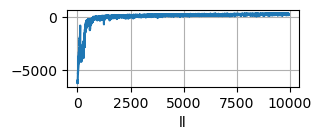

In [13]:
training_metrics = train_meta_model(
    gnp,
    md,
    training_steps=10_000,
    batch_size=2,
    learning_rate=1e-3,
    final_learning_rate=5e-5,
    loss_function='npml',
    include_ctxt_in_trgt=True,
    ctxt_proportion_range=(0.2, 0.8),
    task_subsample_fraction=0.2,
)

fig, axes = plt.subplots(1, len(training_metrics), figsize=(3*len(training_metrics), 1))
if not isinstance(axes, list):
    axes = [axes]
omitted_steps = 50
for i, (key, value) in enumerate(training_metrics.items()):
    axes[i].plot(value[omitted_steps:])
    axes[i].set_xlabel(key)
    axes[i].grid()
plt.show()

In [ ]:
# torch.save(gnp, '../saved_models/tetouan-convgnp-32-32-3')
# gnp = torch.load('../saved_models/tetouan-convgnp-32-32-3', weights_only=False)

100%|██████████| 10000/10000 [28:57<00:00,  5.76it/s, elbo=-128, e_ll=-104, kl=23.7, Epochs=1e+4]    


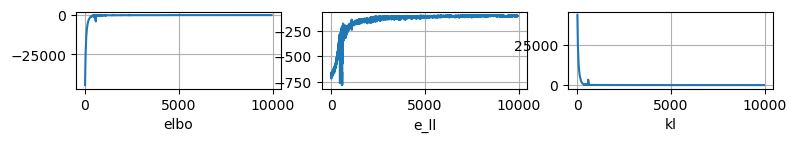

In [ ]:
# training_metrics = train_meta_model(
#     convsgnp,
#     md,
#     training_steps=10_000,
#     batch_size=5,
#     learning_rate=1e-3,
#     final_learning_rate=5e-5,
#     num_samples=5,
#     loss_function='vi',
# )

# fig, axes = plt.subplots(1, len(training_metrics), figsize=(3*len(training_metrics), 1))
# omitted_steps = 50
# for i, (key, value) in enumerate(training_metrics.items()):
#     axes[i].plot(value[omitted_steps:])
#     axes[i].set_xlabel(key)
#     axes[i].grid()
# plt.show()

100%|██████████| 10000/10000 [36:49<00:00,  4.53it/s, elbo=3.79e+3, e_ll=4.11e+3, kl=316, covariance_function.p1.sigma_f=0.758, covariance_function.p2.sigma_f=0.21, covariance_function.se.sigma_f=0.237, sigma_y=0.0959, Epochs=1e+4]    


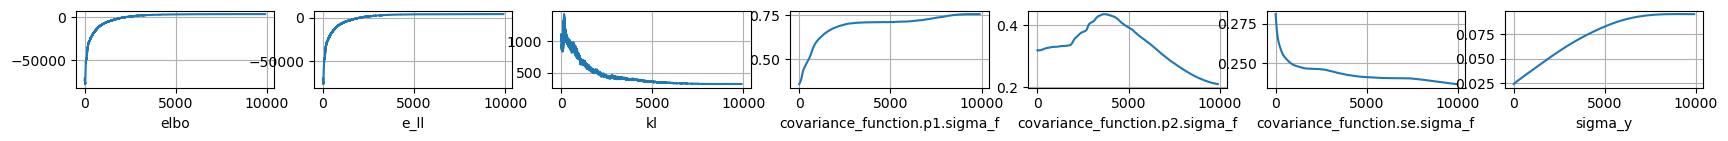

In [8]:
training_metrics = train_meta_model(
    sgnp,
    md,
    training_steps=10_000,
    batch_size=2,
    learning_rate=1e-3,
    final_learning_rate=5e-5,
    num_samples=5,
    loss_function='vi',
)

fig, axes = plt.subplots(1, len(training_metrics), figsize=(3*len(training_metrics), 1))
omitted_steps = 100
for i, (key, value) in enumerate(training_metrics.items()):
    axes[i].plot(value[omitted_steps:])
    axes[i].set_xlabel(key)
    axes[i].grid()
plt.show()

### Visualise test predictions

In [31]:
X_c, y_c, X_t, y_t = *zone2_ctxt, *zone2_trgt

################## Train SVGP ##########################
# svgp_prior = sparse_gp.GPPrior(covariance_function='tetouan',
#                           num_inputs=3,
#                           p1=p1_raw / X_std[0],
#                           p2=p2_raw / X_std[0],
#                          )
# svgp = sparse_gp.SparseVariationalGaussianProcess(x_dim=3,
#                                                   num_inducing=512,
#                                                   likelihood=sparse_gp.GaussianLikelihood(sigma_y = 0.02, train_sigma_y=True),
#                                                   prior=svgp_prior,
#                                                   use_titsias=False,
#                                                   )
# svgp.init_inducing_variables(X_c, y_c)

# svgp_training_metrics = train_gp(
#     svgp,
#     X_c,
#     y_c,
#     epochs=10_000,
#     learning_rate=1e-3,
#     final_learning_rate=5e-5,
#     svgp=True,
#     num_samples=5,
# )

# fig, axes = plt.subplots(1, len(svgp_training_metrics), figsize=(3*len(svgp_training_metrics), 1))
# omitted_steps = 50
# for i, (key, value) in enumerate(svgp_training_metrics.items()):
#     axes[i].plot(value[omitted_steps:])
#     axes[i].set_xlabel(key)
#     axes[i].grid()
# plt.show()
#############################################################


with torch.no_grad():
    mult_predictive = gnp(X_c, y_c, X_t)
    predictive = torch.distributions.Normal(mult_predictive.mean, mult_predictive.variance.sqrt())
    # predictive = sgnp(X_t, X_c, y_c)
    # predictive = convsgnp(X_t, X_c, y_c)
    # predictive = svgp(X_t, X_c, y_c)

print(predictive.log_prob(y_t.squeeze()).mean(), predictive.log_prob(y_t.squeeze()).std())


tensor(-7.9449) tensor(4.6980)
